In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Step 2: Load Datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_features = pd.read_csv("features.csv")
df_stores = pd.read_csv("stores.csv")

In [3]:
# Step 3: Merge Datasets
df = df_train.merge(df_features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(df_stores, on="Store", how="left")

In [4]:
# Step 4: Date Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day

In [5]:
# Step 5: Sort for lag features
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)
df['Weekly_Sales_Lag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Weekly_Sales_Lag7'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(7)

In [6]:
# Step 6: Drop NA (from lag)
df.dropna(inplace=True)


In [7]:
# Step 7: Define Features and Target
features = [
    'Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Size', 'Year', 'Month', 'Week', 'Weekly_Sales_Lag1', 'Weekly_Sales_Lag7',
    'Type_B', 'Type_C', 'IsHoliday_True'  
]



if 'Type_B' not in df.columns:
    df = pd.get_dummies(df, columns=['Type', 'IsHoliday'], drop_first=True)
X = df[features]
y = df['Weekly_Sales']

In [8]:
# Step 8: Train-Test Split (Time-Based)
df['Date'] = pd.to_datetime(df['Date'])
X_train = X[df['Date'] < "2012-10-01"]
y_train = y[df['Date'] < "2012-10-01"]
X_val = X[df['Date'] >= "2012-10-01"]
y_val = y[df['Date'] >= "2012-10-01"]

In [9]:
# Step 9: Train or Load Model
model_path = "walmart_model.h5"

if os.path.exists(model_path):
    model = joblib.load(model_path)
    print(" Loaded pre-trained model from walmart_model.h5")
else:
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
    model.fit(X_train, y_train)
    joblib.dump(model, model_path)
    print(" Model trained and saved to walmart_model.h5")


 Model trained and saved to walmart_model.h5


In [10]:
# Step 10: Evaluate
preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"\n Validation RMSE: {rmse:.2f}")


 Validation RMSE: 3230.94


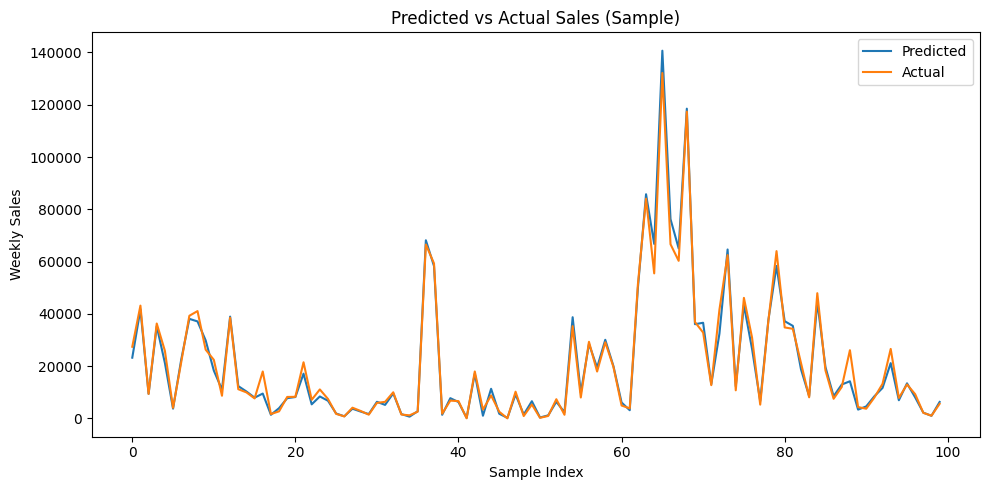

In [11]:
# Step 11: Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(preds[:100], label="Predicted")
plt.plot(y_val.values[:100], label="Actual")
plt.title("Predicted vs Actual Sales (Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.tight_layout()
plt.show()